# Atividade 2: Gradiente Descendente e Redes Neurais

**Disciplina:** Matemática Computacional  
**Aluno:** Alessandro Reali Lopes Silva

### Este notebook apresenta a implementação e análise visual do algoritmo Gradiente Descendente, aplicado tanto em Regressão Linear quanto na otimização de Redes Neurais (Backpropagation).

#### O trabalho está estruturado para atender aos seguintes requisitos:
1.  **Gradiente Descendente (Regressão Linear):** Implementar o algoritmo para ajuste de uma reta ($y = mx + b$), com visualização dinâmica do ajuste dos parâmetros e da redução do erro (SSR) a cada iteração.
2.  **Análise de Hiperparâmetros:** Testar e comparar o comportamento da convergência utilizando diferentes taxas de aprendizado (*Learning Rates*), monitorando o *Step Size* e os valores de intercepto.
3.  **Variações do Algoritmo:** Implementar e comparar o desempenho do **Gradiente Descendente Estocástico (SGD)** e **Mini-Batch** (2 samples) contra o método padrão (Batch).
4.  **Redes Neurais (Backpropagation):** Implementar a arquitetura de rede neural proposta, utilizando a regra da cadeia para calcular gradientes e atualizar os pesos.
5.  **Otimização de Parâmetros:** Realizar a otimização simultânea de 3 parâmetros e monitorar a evolução específica de pesos (ex: $b_3$) até a condição de parada.

---

## 📑 Sumário

- [Parte A: Gradiente Descendente Passo-a-Passo (Regressão Linear)](#parte-a-gradiente-descendente-passo-a-passo-regressão-linear)
- [Parte B: Gradiente Descendente com Dois Parâmetros](#parte-b-gradiente-descendente-com-dois-parâmetros)
- [Parte C: Gradiente Descendente Estocástico e Mini-Batch](#parte-c-gradiente-descendente-estocástico-e-mini-batch)
- [Parte D: Redes Neurais com Backpropagation](#parte-d-redes-neurais-com-backpropagation)

---

**[← Voltar ao README Principal](../readme.md)** | **[Anterior: Atividade 1](./atividade1.ipynb)**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from utils import vetor_para_latex, matriz_para_latex

# ==============================================================================
# DADOS E CONFIGURAÇÕES GLOBAIS
# ==============================================================================

DADOS_TREINO = [(0.5, 1.4), (2.3, 1.9), (2.9, 3.2)]  # Lista de tuplas (x, y)

MAX_INTERACOES = 1000       # Número máximo de iterações para o algoritmo de otimização
PRECISAO = 0.0001           # Critério de parada baseado na precisão do ajuste
INTERCEPTO = 0.0            # Valor inicial do intercepto na regressão linear
INCLINACAO = 1.0            # Valor inicial da inclinação na regressão linear
TAXA_APRENDIZADO = 0.01     # Taxa de aprendizado para o algoritmo de otimização

# ==============================================================================
# FUNÇÕES AUXILIARES
# ==============================================================================

def extrair_xy(dados):
    """Extrai arrays X e Y de uma lista de tuplas (x, y)."""
    x = np.array([ponto[0] for ponto in dados])
    y = np.array([ponto[1] for ponto in dados])
    return x, y


def calcular_residuos(intercepto, inclinacao, dados=DADOS_TREINO):
    """Calcula os resíduos (diferença entre valores observados e preditos)."""
    dados_x, dados_y = extrair_xy(dados)
    y_predito = inclinacao * dados_x + intercepto
    residuos = dados_y - y_predito
    return residuos


def executar_gradiente(
        taxa_aprendizado=TAXA_APRENDIZADO,
        intercepto_inicial=INTERCEPTO,
        inclinacao_inicial=INCLINACAO,
        max_interacoes=MAX_INTERACOES,
        precisao=PRECISAO,
        dados=DADOS_TREINO,
        otimizar_inclinacao=False,
        verbose=True,
    ) -> dict:
    """
    Executa o algoritmo de Gradiente Descendente com logs detalhados.
    
    Pode otimizar apenas o intercepto ou ambos os parâmetros.
    Exibe no máximo 7 linhas de iteração: 0-2, reticências, e as 3 últimas.
    
    Parameters
    ----------
    taxa_aprendizado : float
        Taxa de aprendizado para atualização dos parâmetros.
    intercepto_inicial : float
        Valor inicial do intercepto.
    inclinacao_inicial : float
        Valor inicial da inclinação.
    max_interacoes : int
        Número máximo de iterações.
    precisao : float
        Critério de parada (step size mínimo).
    dados : list of tuples
        Lista de tuplas (x, y) com os dados de treino.
    otimizar_inclinacao : bool
        Se False, apenas intercepto é otimizado (inclinação fica fixa).
        Se True, ambos são otimizados.
    verbose : bool
        Se True, exibe logs em Markdown.
    
    Returns
    -------
    dict : Dicionário com históricos e parâmetros finais
    """
    resultado = {
        'intercepto_final': None,
        'inclinacao_final': None,
        'historico_ssr': [],
        'historico_intercepto': [],
        'historico_inclinacao': [],
        'historico_step_size_b': [],
        'historico_step_size_m': [],
        'historico_gradiente_b': [],
        'historico_gradiente_m': [],
        'taxa_aprendizado': taxa_aprendizado,
        'iteracoes_totais': 0,
        'status': 'Error',
        'otimizar_inclinacao': otimizar_inclinacao
    }

    intercepto_atual = intercepto_inicial
    inclinacao_atual = inclinacao_inicial
    
    dados_x, dados_y = extrair_xy(dados)

    # Inicializar tabela em Markdown
    if otimizar_inclinacao:
        header = """| Iteração | Old b | Old m | Grad b | Grad m | Step b | Step m | New b | New m | SSR |
|---|---|---|---|---|---|---|---|---|---|"""
    else:
        header = """| Iteração | Old b | Gradiente | Step Size | New b | SSR |
|---|---|---|---|---|---|"""
    
    linhas_iteracao = []

    for i in range(max_interacoes):
        residuos = dados_y - (inclinacao_atual * dados_x + intercepto_atual)
        ssr_atual = np.sum(residuos ** 2)
        
        resultado['historico_ssr'].append(ssr_atual)
        resultado['historico_intercepto'].append(intercepto_atual)
        resultado['historico_inclinacao'].append(inclinacao_atual)

        # Calcular gradientes
        gradiente_b = -2 * np.sum(residuos)
        gradiente_m = -2 * np.sum(residuos * dados_x)
        
        # Calcular step sizes
        step_size_b = gradiente_b * taxa_aprendizado
        step_size_m = gradiente_m * taxa_aprendizado
        
        resultado['historico_gradiente_b'].append(gradiente_b)
        resultado['historico_step_size_b'].append(step_size_b)
        
        # Atualizar parâmetros
        intercepto_novo = intercepto_atual - step_size_b
        
        if otimizar_inclinacao:
            resultado['historico_gradiente_m'].append(gradiente_m)
            resultado['historico_step_size_m'].append(step_size_m)
            inclinacao_novo = inclinacao_atual - step_size_m
            
            # Guardar linha para possível exibição
            linhas_iteracao.append(
                f"| {i} | {intercepto_atual:.6f} | {inclinacao_atual:.6f} | {gradiente_b:.6f} | {gradiente_m:.6f} | {step_size_b:.6f} | {step_size_m:.6f} | {intercepto_novo:.6f} | {inclinacao_novo:.6f} | {ssr_atual:.6f} |"
            )
        else:
            inclinacao_novo = inclinacao_atual
            
            # Guardar linha para possível exibição
            linhas_iteracao.append(
                f"| {i} | {intercepto_atual:.6f} | {gradiente_b:.6f} | {step_size_b:.6f} | {intercepto_novo:.6f} | {ssr_atual:.6f} |"
            )

        intercepto_atual = intercepto_novo
        inclinacao_atual = inclinacao_novo

        # Verificar condição de parada
        if otimizar_inclinacao:
            # Ambos os parâmetros devem estar abaixo da precisão
            if abs(step_size_b) < precisao and abs(step_size_m) < precisao:
                status = f"Parada por convergência na iteração {i}"
                break
        else:
            # Apenas intercepto
            if abs(step_size_b) < precisao:
                status = f"Parada por convergência na iteração {i}"
                break
    else:
        status = f"Parada por número máximo de iterações ({max_interacoes})"

    resultado['intercepto_final'] = intercepto_atual
    resultado['inclinacao_final'] = inclinacao_atual
    resultado['iteracoes_totais'] = i + 1
    resultado['status'] = status

    # Montar tabela limitada a 7 linhas de iteração
    if len(linhas_iteracao) > 6:
        if otimizar_inclinacao:
            linhas_visiveis = linhas_iteracao[:3] + ["| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |"] + linhas_iteracao[-3:]
        else:
            linhas_visiveis = linhas_iteracao[:3] + ["| ... | ... | ... | ... | ... | ... |"] + linhas_iteracao[-3:]
    else:
        linhas_visiveis = linhas_iteracao

    if verbose:
        log = f"""
### Logs (taxa = {taxa_aprendizado}, otimizar inclinação = {otimizar_inclinacao})
{header}
{'\n'.join(linhas_visiveis)}
**{status}**
"""
    
    display(Markdown(log))

    return resultado

## Parte A: Gradiente Descendente Passo-a-Passo (Regressão Linear)

**Referência:** Slides 156 a 213 (Gradient Descent, Step-by-Step)

**Objetivo:**
Implementar o algoritmo de Gradiente Descendente "do zero" para ajustar uma reta aos dados. O foco é visualizar o processo de aprendizado iterativo e entender como os parâmetros (inclinação e intercepto) são atualizados.

**Requisitos Específicos:**
1.  **Loop de Treinamento:** Rodar até atingir uma condição de parada.
2.  **Condições de Parada (Duplas):**
    * Número máximo de iterações (segurança).
    * Tamanho do passo (*Step Size*) muito pequeno (precisão atingida).
3.  **Logs:** Imprimir *Step Size*, *Old Intercept* e *New Intercept* a cada passo.
4.  **Visualização:** Mostrar a reta se movendo dinamicamente.
5.  **Análise:** Comparar duas *Learning Rates* diferentes plotando a curva de erro (Loss Curve).


### Logs (taxa = 0.01, otimizar inclinação = False)
| Iteração | Old b | Gradiente | Step Size | New b | SSR |
|---|---|---|---|---|---|
| 0 | 0.000000 | -1.600000 | -0.016000 | 0.016000 | 1.060000 |
| 1 | 0.016000 | -1.504000 | -0.015040 | 0.031040 | 1.035168 |
| 2 | 0.031040 | -1.413760 | -0.014138 | 0.045178 | 1.013226 |
| ... | ... | ... | ... | ... | ... |
| 81 | 0.264891 | -0.010653 | -0.000107 | 0.264998 | 0.846676 |
| 82 | 0.264998 | -0.010014 | -0.000100 | 0.265098 | 0.846675 |
| 83 | 0.265098 | -0.009413 | -0.000094 | 0.265192 | 0.846674 |
**Parada por convergência na iteração 83**



### Logs (taxa = 0.1, otimizar inclinação = False)
| Iteração | Old b | Gradiente | Step Size | New b | SSR |
|---|---|---|---|---|---|
| 0 | 0.000000 | -1.600000 | -0.160000 | 0.160000 | 1.060000 |
| 1 | 0.160000 | -0.640000 | -0.064000 | 0.224000 | 0.880800 |
| 2 | 0.224000 | -0.256000 | -0.025600 | 0.249600 | 0.852128 |
| ... | ... | ... | ... | ... | ... |
| 7 | 0.266230 | -0.002621 | -0.000262 | 0.266492 | 0.846667 |
| 8 | 0.266492 | -0.001049 | -0.000105 | 0.266597 | 0.846667 |
| 9 | 0.266597 | -0.000419 | -0.000042 | 0.266639 | 0.846667 |
**Parada por convergência na iteração 9**


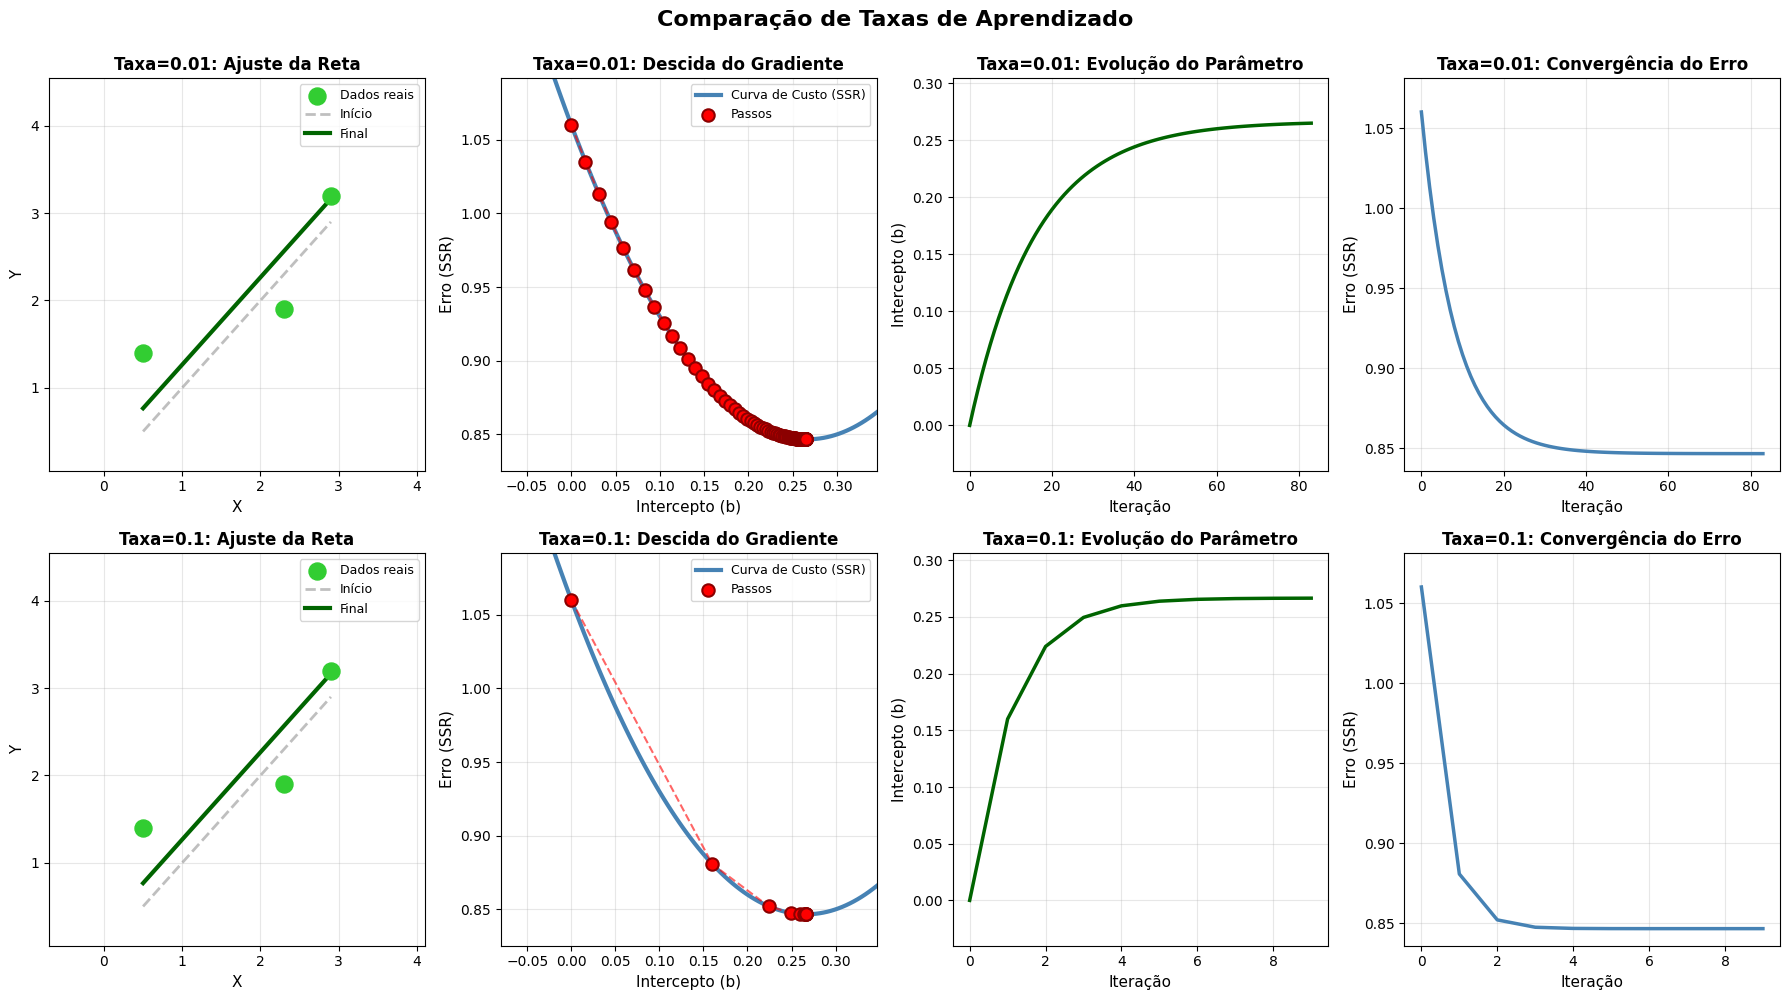


## Resumo Comparativo das Taxas de Aprendizado

| Taxa | Iterações | b Final | SSR Final | Status |
|---|---|---|---|---|
| 0.01 | 84 | 0.265192 | 0.846674 | Parada por convergência na iteração 83 |
| 0.1 | 10 | 0.266639 | 0.846667 | Parada por convergência na iteração 9 |



In [2]:
# ==============================================================================
# VARIÁVEIS CONFIGURÁVEIS - Altere aqui os parâmetros das funções
# ==============================================================================

TAXAS_APRENDIZADO_TESTE = [0.01, 0.1]           # Taxas a serem comparadas
INTERCEPTO_INICIAL_TESTE = 0.0                  # Intercepto inicial
INCLINACAO_TESTE = 1.0                          # Inclinação (mantém fixa)
MAX_ITERACOES_TESTE = 1000                      # Máximo de iterações
PRECISAO_TESTE = 0.0001                         # Critério de convergência

# Configurações de visualização (ajuste dinâmico de limites)
MARGEM_GRAFICO = 0.3                            # Margem proporcional ao redor dos dados (30%)

# ==============================================================================
# EXECUÇÃO COM DIFERENTES TAXAS DE APRENDIZADO
# ==============================================================================

# Extrair X e Y para visualizações
dados_x, dados_y = extrair_xy(DADOS_TREINO)

resumo_dados = []

# Plotar cada taxa em uma linha separada (4 gráficos por taxa)
num_taxas = len(TAXAS_APRENDIZADO_TESTE)
fig, axes = plt.subplots(num_taxas, 4, figsize=(18, 5 * num_taxas))

# Garantir que axes seja sempre 2D
if num_taxas == 1:
    axes = axes.reshape(1, -1)

fig.suptitle("Comparação de Taxas de Aprendizado", fontsize=16, fontweight='bold', y=0.995)

for idx, taxa in enumerate(TAXAS_APRENDIZADO_TESTE):   
    resultado = executar_gradiente(
        taxa_aprendizado=taxa,
        intercepto_inicial=INTERCEPTO_INICIAL_TESTE,
        inclinacao_inicial=INCLINACAO_TESTE,
        max_interacoes=MAX_ITERACOES_TESTE,
        precisao=PRECISAO_TESTE,
        dados=DADOS_TREINO,
        verbose=True
    )

    # Calcular limites dinâmicos para o gráfico da parábola
    b_min = min(resultado['historico_intercepto'])
    b_max = max(resultado['historico_intercepto'])
    b_range = b_max - b_min
    
    # Adicionar margem proporcional
    if b_range == 0:  # Caso não haja movimento (convergência imediata)
        b_range = 1.0
    
    b_limite_inf = b_min - MARGEM_GRAFICO * b_range
    b_limite_sup = b_max + MARGEM_GRAFICO * b_range
    
    # Gera a parábola de fundo teórica (adaptada ao range de movimento)
    b_teste = np.linspace(b_limite_inf, b_limite_sup, 100)
    ssr_teste = [np.sum(calcular_residuos(b, INCLINACAO_TESTE, DADOS_TREINO)**2) for b in b_teste]

    # Gráfico 1: Dados e Reta (Início vs Final)
    ax1 = axes[idx, 0]
    ax1.scatter(dados_x, dados_y, color='limegreen', s=150, label='Dados reais', zorder=5)
    
    # Reta inicial (transparente)
    y_inicial = INCLINACAO_TESTE * dados_x + resultado['historico_intercepto'][0]
    ax1.plot(dados_x, y_inicial, color='gray', ls='--', linewidth=2, alpha=0.5, label='Início')
    
    # Reta final (destacada)
    y_final = INCLINACAO_TESTE * dados_x + resultado['intercepto_final']
    ax1.plot(dados_x, y_final, color='darkgreen', linewidth=3, label='Final')
    
    ax1.set_xlabel('X', fontsize=11)
    ax1.set_ylabel('Y', fontsize=11)
    ax1.set_title(f'Taxa={taxa}: Ajuste da Reta', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Limites dinâmicos para dados
    x_margin = (dados_x.max() - dados_x.min()) * 0.5
    y_margin = (dados_y.max() - dados_y.min()) * 0.75
    ax1.set_xlim(dados_x.min() - x_margin, dados_x.max() + x_margin)
    ax1.set_ylim(dados_y.min() - y_margin, dados_y.max() + y_margin)

    # Gráfico 2: Parábola e Passos (com limites dinâmicos)
    ax2 = axes[idx, 1]
    ax2.plot(b_teste, ssr_teste, color='steelblue', linewidth=3, label='Curva de Custo (SSR)')
    
    # Plotar os passos
    ax2.scatter(resultado['historico_intercepto'], 
               resultado['historico_ssr'],
               color='red', s=80, zorder=5, label='Passos', edgecolors='darkred', linewidth=1.5)
    
    # Conectar os passos com linha tracejada
    ax2.plot(resultado['historico_intercepto'], 
            resultado['historico_ssr'],
            color='red', linestyle='--', linewidth=1.5, alpha=0.6)
    
    ax2.set_xlabel('Intercepto (b)', fontsize=11)
    ax2.set_ylabel('Erro (SSR)', fontsize=11)
    ax2.set_title(f'Taxa={taxa}: Descida do Gradiente', fontsize=12, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)
    
    # Limites dinâmicos baseados no movimento
    ax2.set_xlim(b_limite_inf, b_limite_sup)
    
    # Limites dinâmicos para SSR
    ssr_min = min(resultado['historico_ssr'])
    ssr_max = max(resultado['historico_ssr'])
    ssr_range = ssr_max - ssr_min
    if ssr_range == 0:
        ssr_range = 1.0
    ax2.set_ylim(ssr_min - 0.1 * ssr_range, ssr_max + 0.15 * ssr_range)
    
    # Gráfico 3: Evolução do intercepto
    ax3 = axes[idx, 2]
    ax3.plot(resultado['historico_intercepto'], linewidth=2.5, color='darkgreen')
    ax3.set_xlabel('Iteração', fontsize=11)
    ax3.set_ylabel('Intercepto (b)', fontsize=11)
    ax3.set_title(f'Taxa={taxa}: Evolução do Parâmetro', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    
    # Limites dinâmicos
    ax3.set_ylim(b_min - 0.15 * b_range, b_max + 0.15 * b_range)

    # Gráfico 4: Erro (SSR) ao longo das iterações
    ax4 = axes[idx, 3]
    ax4.plot(resultado['historico_ssr'], linewidth=2.5, color='steelblue')
    ax4.set_xlabel('Iteração', fontsize=11)
    ax4.set_ylabel('Erro (SSR)', fontsize=11)
    ax4.set_title(f'Taxa={taxa}: Convergência do Erro', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Limites dinâmicos
    ax4.set_ylim(ssr_min - 0.05 * ssr_range, ssr_max + 0.1 * ssr_range)
    
    resumo_dados.append({
        'Taxa': taxa,
        'Iterações': resultado['iteracoes_totais'],
        'b Final': f"{resultado['intercepto_final']:.6f}",
        'SSR Final': f"{resultado['historico_ssr'][-1]:.6f}",
        'Status': resultado['status']
    })

plt.tight_layout()
plt.show()

# ==============================================================================
# RESUMO COMPARATIVO
# ==============================================================================

display(Markdown(f"""
## Resumo Comparativo das Taxas de Aprendizado

| Taxa | Iterações | b Final | SSR Final | Status |
|---|---|---|---|---|
{'\n'.join(f"| {dados['Taxa']} | {dados['Iterações']} | {dados['b Final']} | {dados['SSR Final']} | {dados['Status']} |" for dados in resumo_dados)}

"""))

## Parte B: Gradiente Descendente com Dois Parâmetros

**Referência:** Slides 302 a 335 (Gradient Descent - Two Parameters)

**Objetivo:**
Estender o algoritmo de Gradiente Descendente para otimizar simultaneamente dois parâmetros: **inclinação (m)** e **intercepto (b)**. O foco é visualizar como ambos evoluem e convergem para os valores ótimos que minimizam o erro.

**Requisitos Específicos:**
1.  **Loop de Treinamento:** Rodar até atingir uma condição de parada.
2.  **Condições de Parada (Duplas):**
    * Número máximo de iterações (segurança).
    * Ambos os *Step Sizes* (b e m) muito pequenos (precisão atingida).
3.  **Logs:** Imprimir *Gradientes*, *Step Sizes* e valores atualizados de ambos os parâmetros a cada passo.
4.  **Visualização:** Mostrar a evolução simultânea da inclinação e intercepto.
5.  **Análise:** Comparar duas *Learning Rates* diferentes mostrando a convergência de ambos os parâmetros.



### Logs (taxa = 0.01, otimizar inclinação = True)
| Iteração | Old b | Old m | Grad b | Grad m | Step b | Step m | New b | New m | SSR |
|---|---|---|---|---|---|---|---|---|---|
| 0 | 0.000000 | 1.000000 | -1.600000 | -0.800000 | -0.016000 | -0.008000 | 0.016000 | 1.008000 | 1.060000 |
| 1 | 0.016000 | 1.008000 | -1.412800 | -0.394400 | -0.014128 | -0.003944 | 0.030128 | 1.011944 | 1.031120 |
| 2 | 0.030128 | 1.011944 | -1.283070 | -0.123303 | -0.012831 | -0.001233 | 0.042959 | 1.013177 | 1.011055 |
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |
| 405 | 0.939853 | 0.644803 | -0.010132 | 0.004317 | -0.000101 | 0.000043 | 0.939954 | 0.644760 | 0.444668 |
| 406 | 0.939954 | 0.644760 | -0.010017 | 0.004268 | -0.000100 | 0.000043 | 0.940054 | 0.644717 | 0.444667 |
| 407 | 0.940054 | 0.644717 | -0.009902 | 0.004219 | -0.000099 | 0.000042 | 0.940153 | 0.644675 | 0.444666 |
**Parada por convergência na iteração 407**



### Logs (taxa = 0.05, otimizar inclinação = True)
| Iteração | Old b | Old m | Grad b | Grad m | Step b | Step m | New b | New m | SSR |
|---|---|---|---|---|---|---|---|---|---|
| 0 | 0.000000 | 1.000000 | -1.600000 | -0.800000 | -0.080000 | -0.040000 | 0.080000 | 1.040000 | 1.060000 |
| 1 | 0.080000 | 1.040000 | -0.664000 | 1.228000 | -0.033200 | 0.061400 | 0.113200 | 0.978600 | 0.978000 |
| 2 | 0.113200 | 0.978600 | -1.164760 | -0.106580 | -0.058238 | -0.005329 | 0.171438 | 0.983929 | 0.913215 |
| ... | ... | ... | ... | ... | ... | ... | ... | ... | ... |
| 105 | 0.946785 | 0.641849 | -0.002209 | 0.000941 | -0.000110 | 0.000047 | 0.946896 | 0.641802 | 0.444618 |
| 106 | 0.946896 | 0.641802 | -0.002083 | 0.000887 | -0.000104 | 0.000044 | 0.947000 | 0.641758 | 0.444618 |
| 107 | 0.947000 | 0.641758 | -0.001964 | 0.000837 | -0.000098 | 0.000042 | 0.947098 | 0.641716 | 0.444617 |
**Parada por convergência na iteração 107**


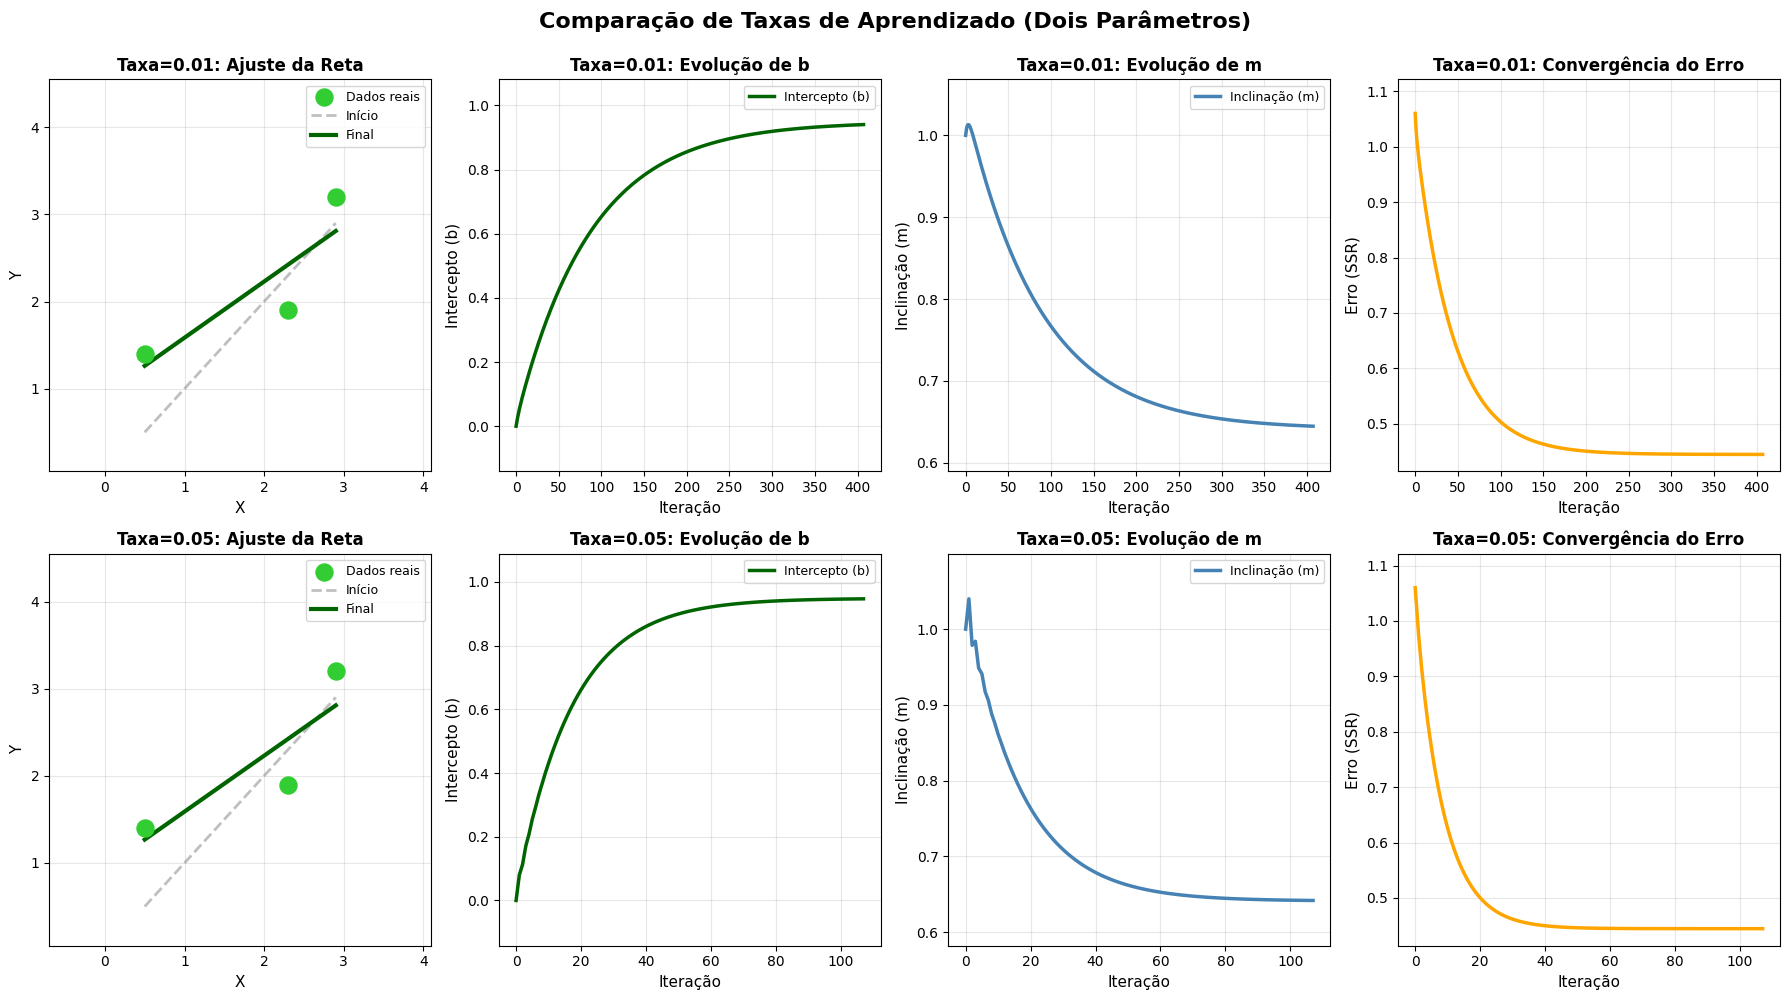


## Resumo Comparativo das Taxas de Aprendizado (Dois Parâmetros)

| Taxa | Iterações | m Final | b Final | SSR Final | Status |
|---|---|---|---|---|---|
| 0.01 | 408 | 0.644675 | 0.940153 | 0.444666 | Parada por convergência na iteração 407 |
| 0.05 | 108 | 0.641716 | 0.947098 | 0.444617 | Parada por convergência na iteração 107 |



In [3]:
# ==============================================================================
# VARIÁVEIS CONFIGURÁVEIS - Altere aqui os parâmetros das funções
# ==============================================================================

TAXAS_APRENDIZADO_TESTE_B = [0.01, 0.05]       # Taxas a serem comparadas
INTERCEPTO_INICIAL_B = 0.0                     # Intercepto inicial
INCLINACAO_INICIAL_B = 1.0                     # Inclinação inicial
MAX_ITERACOES_B = 1000                         # Máximo de iterações
PRECISAO_B = 0.0001                            # Critério de convergência

# Configurações de visualização (ajuste dinâmico de limites)
MARGEM_GRAFICO_B = 0.3                         # Margem proporcional ao redor dos dados (30%)

# ==============================================================================
# EXECUÇÃO COM DIFERENTES TAXAS DE APRENDIZADO (2 PARÂMETROS)
# ==============================================================================

# Extrair X e Y para visualizações
dados_x, dados_y = extrair_xy(DADOS_TREINO)

resumo_dados_b = []

# Plotar cada taxa em uma linha separada (4 gráficos por taxa)
num_taxas_b = len(TAXAS_APRENDIZADO_TESTE_B)
fig, axes = plt.subplots(num_taxas_b, 4, figsize=(18, 5 * num_taxas_b))

# Garantir que axes seja sempre 2D
if num_taxas_b == 1:
    axes = axes.reshape(1, -1)

fig.suptitle("Comparação de Taxas de Aprendizado (Dois Parâmetros)", fontsize=16, fontweight='bold', y=0.995)

for idx, taxa in enumerate(TAXAS_APRENDIZADO_TESTE_B):   
    resultado = executar_gradiente(
        taxa_aprendizado=taxa,
        intercepto_inicial=INTERCEPTO_INICIAL_B,
        inclinacao_inicial=INCLINACAO_INICIAL_B,
        max_interacoes=MAX_ITERACOES_B,
        precisao=PRECISAO_B,
        dados=DADOS_TREINO,
        otimizar_inclinacao=True,
        verbose=True
    )

    # Calcular limites dinâmicos para os parâmetros
    b_min = min(resultado['historico_intercepto'])
    b_max = max(resultado['historico_intercepto'])
    b_range = b_max - b_min
    if b_range == 0:
        b_range = 1.0
    
    m_min = min(resultado['historico_inclinacao'])
    m_max = max(resultado['historico_inclinacao'])
    m_range = m_max - m_min
    if m_range == 0:
        m_range = 1.0
    
    b_limite_inf = b_min - MARGEM_GRAFICO_B * b_range
    b_limite_sup = b_max + MARGEM_GRAFICO_B * b_range
    
    m_limite_inf = m_min - MARGEM_GRAFICO_B * m_range
    m_limite_sup = m_max + MARGEM_GRAFICO_B * m_range
    
    # Gera a parábola de fundo teórica (adaptada ao range de movimento)
    b_teste = np.linspace(b_limite_inf, b_limite_sup, 100)
    ssr_teste = [np.sum(calcular_residuos(b, resultado['inclinacao_final'], DADOS_TREINO)**2) for b in b_teste]

    # Gráfico 1: Dados e Reta (Início vs Final)
    ax1 = axes[idx, 0]
    ax1.scatter(dados_x, dados_y, color='limegreen', s=150, label='Dados reais', zorder=5)
    
    # Reta inicial (transparente)
    y_inicial = resultado['historico_inclinacao'][0] * dados_x + resultado['historico_intercepto'][0]
    ax1.plot(dados_x, y_inicial, color='gray', ls='--', linewidth=2, alpha=0.5, label='Início')
    
    # Reta final (destacada)
    y_final = resultado['inclinacao_final'] * dados_x + resultado['intercepto_final']
    ax1.plot(dados_x, y_final, color='darkgreen', linewidth=3, label='Final')
    
    ax1.set_xlabel('X', fontsize=11)
    ax1.set_ylabel('Y', fontsize=11)
    ax1.set_title(f'Taxa={taxa}: Ajuste da Reta', fontsize=12, fontweight='bold')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)
    
    # Limites dinâmicos para dados
    x_margin = (dados_x.max() - dados_x.min()) * 0.5
    y_margin = (dados_y.max() - dados_y.min()) * 0.75
    ax1.set_xlim(dados_x.min() - x_margin, dados_x.max() + x_margin)
    ax1.set_ylim(dados_y.min() - y_margin, dados_y.max() + y_margin)

    # Gráfico 2: Evolução do Intercepto
    ax2 = axes[idx, 1]
    ax2.plot(resultado['historico_intercepto'], linewidth=2.5, color='darkgreen', label='Intercepto (b)')
    ax2.set_xlabel('Iteração', fontsize=11)
    ax2.set_ylabel('Intercepto (b)', fontsize=11)
    ax2.set_title(f'Taxa={taxa}: Evolução de b', fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=9)
    ax2.set_ylim(b_min - 0.15 * b_range, b_max + 0.15 * b_range)
    
    # Gráfico 3: Evolução da Inclinação
    ax3 = axes[idx, 2]
    ax3.plot(resultado['historico_inclinacao'], linewidth=2.5, color='steelblue', label='Inclinação (m)')
    ax3.set_xlabel('Iteração', fontsize=11)
    ax3.set_ylabel('Inclinação (m)', fontsize=11)
    ax3.set_title(f'Taxa={taxa}: Evolução de m', fontsize=12, fontweight='bold')
    ax3.grid(True, alpha=0.3)
    ax3.legend(fontsize=9)
    ax3.set_ylim(m_min - 0.15 * m_range, m_max + 0.15 * m_range)

    # Gráfico 4: Erro (SSR) ao longo das iterações
    ax4 = axes[idx, 3]
    ax4.plot(resultado['historico_ssr'], linewidth=2.5, color='orange')
    ax4.set_xlabel('Iteração', fontsize=11)
    ax4.set_ylabel('Erro (SSR)', fontsize=11)
    ax4.set_title(f'Taxa={taxa}: Convergência do Erro', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    # Limites dinâmicos para SSR
    ssr_min = min(resultado['historico_ssr'])
    ssr_max = max(resultado['historico_ssr'])
    ssr_range = ssr_max - ssr_min
    if ssr_range == 0:
        ssr_range = 1.0
    ax4.set_ylim(ssr_min - 0.05 * ssr_range, ssr_max + 0.1 * ssr_range)
    
    resumo_dados_b.append({
        'Taxa': taxa,
        'Iterações': resultado['iteracoes_totais'],
        'm Final': f"{resultado['inclinacao_final']:.6f}",
        'b Final': f"{resultado['intercepto_final']:.6f}",
        'SSR Final': f"{resultado['historico_ssr'][-1]:.6f}",
        'Status': resultado['status']
    })

plt.tight_layout()
plt.show()

# ==============================================================================
# RESUMO COMPARATIVO
# ==============================================================================

display(Markdown(f"""
## Resumo Comparativo das Taxas de Aprendizado (Dois Parâmetros)

| Taxa | Iterações | m Final | b Final | SSR Final | Status |
|---|---|---|---|---|---|
{'\n'.join(f"| {dados['Taxa']} | {dados['Iterações']} | {dados['m Final']} | {dados['b Final']} | {dados['SSR Final']} | {dados['Status']} |" for dados in resumo_dados_b)}

"""))

## Parte C: Gradiente Descendente Estocástico e Mini-Batch

**Referência:** Slides 302 a 335 (SGD e Mini-Batch Variants)

**Objetivo:**
Implementar e comparar três variantes do algoritmo de Gradiente Descendente:
1. **Batch Gradient Descent (BGD):** Utiliza todos os dados a cada atualização (Baseline)
2. **Stochastic Gradient Descent (SGD):** Utiliza 1 amostra por atualização
3. **Mini-Batch Gradient Descent:** Utiliza 2 amostras por atualização

**Requisitos Específicos:**
1. **Comparação Visual:** Mostrar convergência de cada variante lado a lado
2. **Estabilidade:** Observar oscilações (SGD/Mini-Batch são mais instáveis que BGD)
3. **Velocidade:** Comparar número de épocas para convergência
4. **Generalização:** SGD e Mini-Batch simulam melhor cenários com muitos dados



### SGD (taxa=0.01)

**Máximo de épocas (500)**
- Épocas totais: 500
- b final: 0.938735
- m final: 0.660551
- SSR final: 0.448011



### Mini-Batch (size=2) (taxa=0.01)

**Máximo de épocas (500)**
- Épocas totais: 500
- b final: 0.938234
- m final: 0.643749
- SSR final: 0.444723


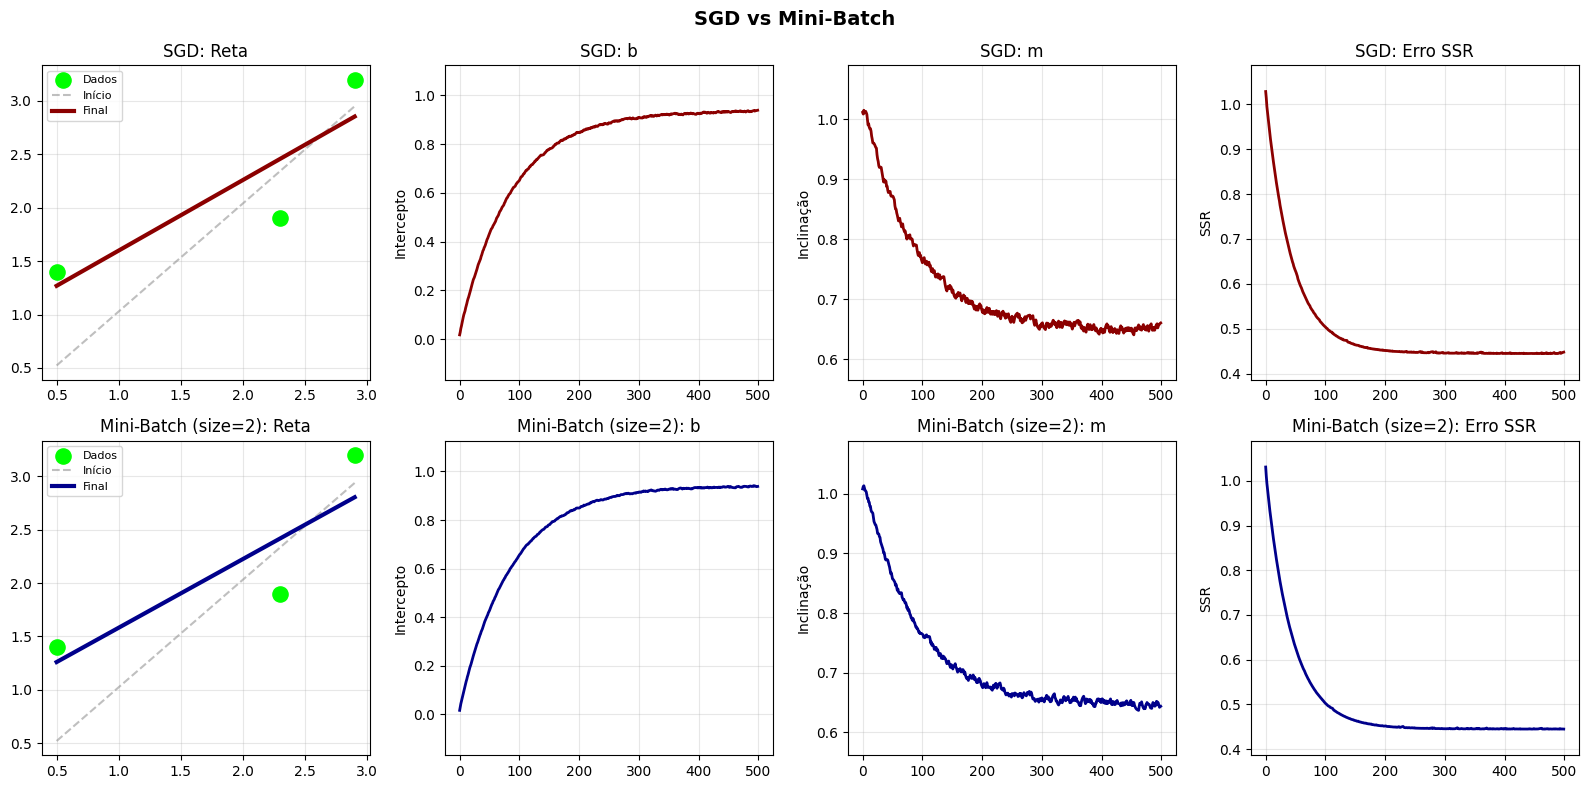


## Resumo: SGD vs Mini-Batch

| Algoritmo | Épocas | b | m | SSR | Status |
|---|---|---|---|---|---|
| SGD | 500 | 0.9387 | 0.6606 | 0.4480 | Máximo de épocas (500) |
| Mini-Batch (size=2) | 500 | 0.9382 | 0.6437 | 0.4447 | Máximo de épocas (500) |


In [4]:
# ==============================================================================
# VARIÁVEIS CONFIGURÁVEIS - Parte C
# ==============================================================================

TAXA_APRENDIZADO_C = 0.01
INTERCEPTO_INICIAL_C = 0.0              
INCLINACAO_INICIAL_C = 1.0              
MAX_EPOCAS_C = 500
PRECISAO_C = 0.001

# ==============================================================================
# FUNÇÃO FOCADA: SGD E MINI-BATCH
# ==============================================================================

def executar_sgd_minibatch(
        taxa_aprendizado=0.01,
        intercepto_inicial=0.0,
        inclinacao_inicial=1.0,
        max_epocas=500,
        precisao=0.001,
        batch_size=1,
        dados=DADOS_TREINO,
        verbose=True,
    ):
    """
    Implementação simplificada de SGD e Mini-Batch.
    
    Otimiza simultaneamente b (intercepto) e m (inclinacao).
    """
    
    # Extrair dados
    x_data, y_data = extrair_xy(dados)
    n_samples = len(x_data)
    
    # Definir modo
    if batch_size == 1:
        modo = "SGD"
    elif batch_size >= n_samples:
        modo = "BGD"
    else:
        modo = f"Mini-Batch (size={batch_size})"
    
    # Inicializar parâmetros
    b = intercepto_inicial
    m = inclinacao_inicial
    
    # Listas para rastrear histórico
    historico_b = []
    historico_m = []
    historico_ssr = []
    
    # LOOP DE ÉPOCAS
    for epoca in range(max_epocas):
        
        # 1. EMBARALHAR DADOS
        indices = np.random.permutation(n_samples)
        x_emb = x_data[indices]
        y_emb = y_data[indices]
        
        # 2. LOOP DE BATCHES
        max_step = 0
        
        for i in range(0, n_samples, batch_size):
            # Obter batch
            x_batch = x_emb[i:i+batch_size]
            y_batch = y_emb[i:i+batch_size]
            
            # 3. CALCULAR RESÍDUOS
            y_pred = m * x_batch + b
            residuos = y_batch - y_pred
            
            # 4. CALCULAR GRADIENTES
            grad_b = -2 * np.sum(residuos)
            grad_m = -2 * np.sum(residuos * x_batch)
            
            # 5. ATUALIZAR PARÂMETROS
            step_b = grad_b * taxa_aprendizado
            step_m = grad_m * taxa_aprendizado
            
            b -= step_b
            m -= step_m
            
            # Rastrear maior passo
            max_step = max(max_step, abs(step_b), abs(step_m))
        
        # 6. CALCULAR ERRO GLOBAL
        y_pred_total = m * x_data + b
        ssr = np.sum((y_data - y_pred_total) ** 2)
        
        # 7. ARMAZENAR HISTÓRICO
        historico_b.append(b)
        historico_m.append(m)
        historico_ssr.append(ssr)
        
        # 8. VERIFICAR CONVERGÊNCIA
        if max_step < precisao:
            status = f"Convergência época {epoca}"
            break
    else:
        status = f"Máximo de épocas ({max_epocas})"
    
    # Exibir logs simples
    if verbose:
        display(Markdown(f"""
### {modo} (taxa={taxa_aprendizado})

**{status}**
- Épocas totais: {epoca + 1}
- b final: {b:.6f}
- m final: {m:.6f}
- SSR final: {ssr:.6f}
"""))
    
    return {
        'historico_b': historico_b,
        'historico_m': historico_m,
        'historico_ssr': historico_ssr,
        'b_final': b,
        'm_final': m,
        'ssr_final': ssr,
        'epocas_totais': epoca + 1,
        'status': status,
        'modo': modo,
    }


# ==============================================================================
# EXECUTAR SGD E MINI-BATCH
# ==============================================================================

dados_x, dados_y = extrair_xy(DADOS_TREINO)

# Executar os dois algoritmos
resultado_sgd = executar_sgd_minibatch(
    taxa_aprendizado=TAXA_APRENDIZADO_C,
    intercepto_inicial=INTERCEPTO_INICIAL_C,
    inclinacao_inicial=INCLINACAO_INICIAL_C,
    max_epocas=MAX_EPOCAS_C,
    precisao=PRECISAO_C,
    batch_size=1,
    dados=DADOS_TREINO,
    verbose=True
)

resultado_minibatch = executar_sgd_minibatch(
    taxa_aprendizado=TAXA_APRENDIZADO_C,
    intercepto_inicial=INTERCEPTO_INICIAL_C,
    inclinacao_inicial=INCLINACAO_INICIAL_C,
    max_epocas=MAX_EPOCAS_C,
    precisao=PRECISAO_C,
    batch_size=2,
    dados=DADOS_TREINO,
    verbose=True
)

# ==============================================================================
# VISUALIZAÇÃO COMPARATIVA
# ==============================================================================

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle("SGD vs Mini-Batch", fontsize=14, fontweight='bold')

for idx, resultado in enumerate([resultado_sgd, resultado_minibatch]):
    color = 'darkred' if idx == 0 else 'darkblue'
    
    # Limites dinâmicos
    b_min, b_max = min(resultado['historico_b']), max(resultado['historico_b'])
    b_range = max(0.1, b_max - b_min)
    
    m_min, m_max = min(resultado['historico_m']), max(resultado['historico_m'])
    m_range = max(0.1, m_max - m_min)
    
    ssr_min, ssr_max = min(resultado['historico_ssr']), max(resultado['historico_ssr'])
    ssr_range = max(0.1, ssr_max - ssr_min)
    
    # Gráfico 1: Reta Final
    ax = axes[idx, 0]
    ax.scatter(dados_x, dados_y, color='lime', s=120, label='Dados', zorder=5)
    y_ini = resultado['historico_m'][0] * dados_x + resultado['historico_b'][0]
    ax.plot(dados_x, y_ini, 'gray', ls='--', alpha=0.5, label='Início')
    y_fim = resultado['m_final'] * dados_x + resultado['b_final']
    ax.plot(dados_x, y_fim, color=color, linewidth=3, label='Final')
    ax.set_title(f"{resultado['modo']}: Reta")
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)
    
    # Gráfico 2: Evolução de b
    ax = axes[idx, 1]
    ax.plot(resultado['historico_b'], color=color, linewidth=2)
    ax.set_title(f"{resultado['modo']}: b")
    ax.set_ylabel('Intercepto')
    ax.set_ylim(b_min - 0.2*b_range, b_max + 0.2*b_range)
    ax.grid(True, alpha=0.3)
    
    # Gráfico 3: Evolução de m
    ax = axes[idx, 2]
    ax.plot(resultado['historico_m'], color=color, linewidth=2)
    ax.set_title(f"{resultado['modo']}: m")
    ax.set_ylabel('Inclinação')
    ax.set_ylim(m_min - 0.2*m_range, m_max + 0.2*m_range)
    ax.grid(True, alpha=0.3)
    
    # Gráfico 4: SSR
    ax = axes[idx, 3]
    ax.plot(resultado['historico_ssr'], color=color, linewidth=2)
    ax.set_title(f"{resultado['modo']}: Erro SSR")
    ax.set_ylabel('SSR')
    ax.set_ylim(ssr_min - 0.1*ssr_range, ssr_max + 0.1*ssr_range)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# RESUMO
# ==============================================================================

display(Markdown(f"""
## Resumo: SGD vs Mini-Batch

| Algoritmo | Épocas | b | m | SSR | Status |
|---|---|---|---|---|---|
| {resultado_sgd['modo']} | {resultado_sgd['epocas_totais']} | {resultado_sgd['b_final']:.4f} | {resultado_sgd['m_final']:.4f} | {resultado_sgd['ssr_final']:.4f} | {resultado_sgd['status']} |
| {resultado_minibatch['modo']} | {resultado_minibatch['epocas_totais']} | {resultado_minibatch['b_final']:.4f} | {resultado_minibatch['m_final']:.4f} | {resultado_minibatch['ssr_final']:.4f} | {resultado_minibatch['status']} |
"""))


## Parte D: Redes Neurais com Backpropagation

**Referência:** Slides 256 a 305 (Neural Networks, Backpropagation)

**Objetivo:**
Implementar uma rede neural simples com **uma camada oculta** e calcular gradientes usando **backpropagation** (regra da cadeia).

**Arquitetura da Rede:**
- **Entrada:** 1 neurônio (x)
- **Camada oculta:** 2 neurônios com ativação ReLU
- **Saída:** 1 neurônio (y)
- **Parâmetros:** b₁, b₂ (bias camada oculta), b₃ (bias saída), pesos w

**Requisitos Específicos:**
1. **Forward Pass:** Calcular predições passando dados pela rede
2. **Backpropagation:** Calcular gradientes usando regra da cadeia (chain rule)
3. **Atualização:** Atualizar todos os pesos e bias simultane
amente
4. **Monitoramento:** Rastrear evolução específica de b₃ até convergência
5. **Visualização:** Mostrar evolução dos parâmetros e erro SSR


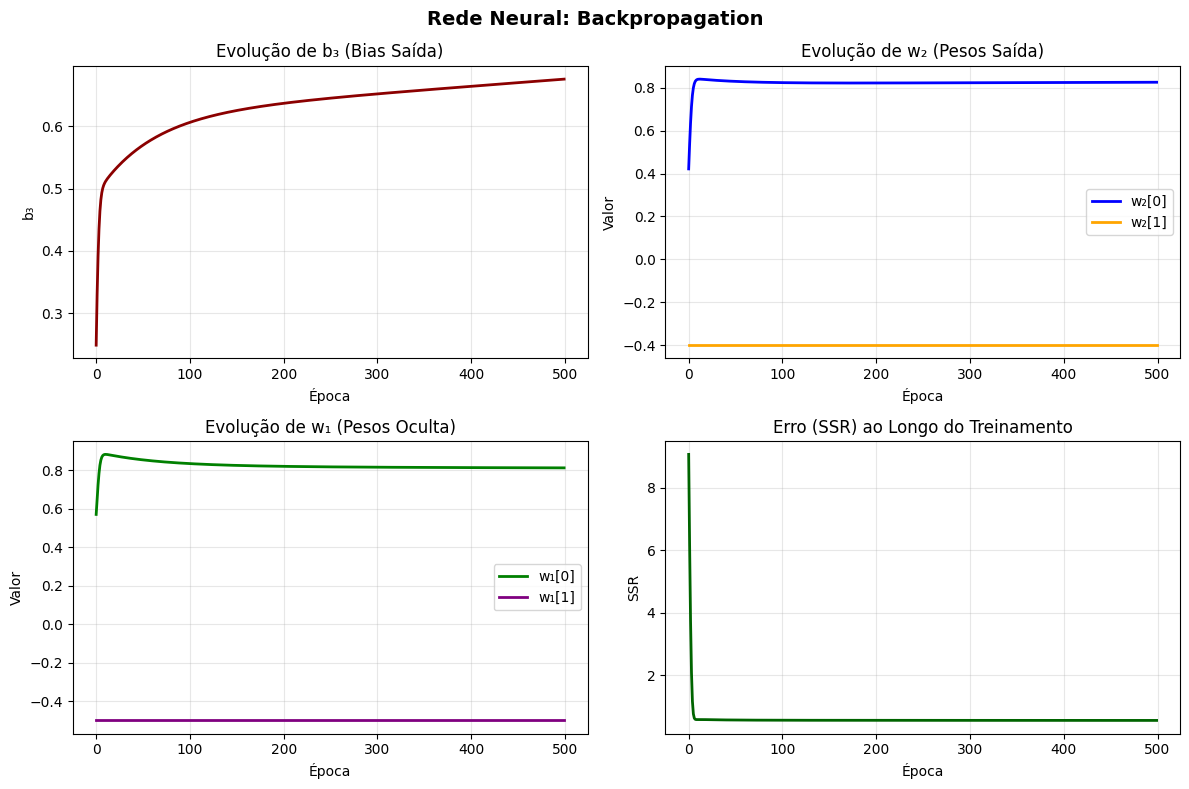


## Resumo: Rede Neural Treinada

### Configuração da Rede
- Entrada: 1
- Camada Oculta: 2 neurônios (ReLU)
- Saída: 1 neurônio

### Resultados do Treinamento
| Métrica | Valor |
|---------|-------|
| Épocas | 500 |
| Status | Máximo de épocas (500) |
| SSR Final | 0.562290 |
| b₃ Final | 0.675827 |

### Parâmetros Finais
**Camada Oculta:**
- w₁ = [0.812838, -0.500000]
- b₁ = [0.1, 0.2] → Atualizados durante treinamento

**Camada Saída:**
- w₂ = [0.825318, -0.400000]
- b₃ = 0.675827


In [5]:
# ==============================================================================
# PARTE D: REDE NEURAL COM BACKPROPAGATION
# ==============================================================================

# ==============================================================================
# VARIÁVEIS CONFIGURÁVEIS - Parte D
# ==============================================================================

TAXA_APRENDIZADO_D = 0.01
MAX_EPOCAS_D = 500
PRECISAO_D = 0.001

# Pesos iniciais (camada oculta: 2 neurônios)
W1_INICIAL = np.array([0.5, -0.5])    # Pesos para camada oculta
B1_INICIAL = np.array([0.1, 0.2])     # Bias camada oculta (b_1, b_2)

# Pesos iniciais (camada saída: 1 neurônio)
W2_INICIAL = np.array([0.3, -0.4])    # Pesos para saída
B3_INICIAL = 0.15                      # Bias saída (b_3)

# ==============================================================================
# CLASSE REDE NEURAL
# ==============================================================================

class RedeNeural:
    """
    Rede Neural com 1 camada oculta (2 neurônios) e 1 saída.
    Implementa Forward Pass e Backpropagation.
    """
    
    def __init__(self, w1, b1, w2, b3):
        """Inicializar pesos"""
        self.w1 = w1.copy()      # Pesos camada oculta
        self.b1 = b1.copy()      # Bias camada oculta
        self.w2 = w2.copy()      # Pesos saída
        self.b3 = b3             # Bias saída
        
        # Históricos
        self.historico_b3 = []
        self.historico_w1 = []
        self.historico_w2 = []
        self.historico_ssr = []
    
    def relu(self, x):
        """Ativação ReLU: max(0, x)"""
        return np.maximum(0, x)
    
    def relu_derivada(self, x):
        """Derivada ReLU: 1 se x > 0, senão 0"""
        return (x > 0).astype(float)
    
    def forward(self, x):
        """
        Forward Pass: Passar dados pela rede.
        
        Camada 1 (Oculta):
          z1 = w1[0]*x + b1[0]
          z2 = w1[1]*x + b1[1]
          a1 = ReLU(z1)
          a2 = ReLU(z2)
        
        Camada 2 (Saída):
          y_pred = w2[0]*a1 + w2[1]*a2 + b3
        """
        
        # Camada oculta
        self.z1 = self.w1[0] * x + self.b1[0]
        self.z2 = self.w1[1] * x + self.b1[1]
        
        self.a1 = self.relu(self.z1)
        self.a2 = self.relu(self.z2)
        
        # Camada saída
        self.y_pred = self.w2[0] * self.a1 + self.w2[1] * self.a2 + self.b3
        
        return self.y_pred
    
    def backward(self, x, y_real, taxa_aprendizado):
        """
        Backpropagation: Calcular gradientes usando regra da cadeia.
        
        1. Erro de saída: δ = y_pred - y_real
        2. Gradiente b3: ∂L/∂b3 = 2 * δ
        3. Gradiente w2: ∂L/∂w2 = 2 * δ * a
        4. Gradiente para camada anterior: δ_oculta = 2 * δ * w2
        5. Gradientes camada oculta: ∂L/∂w1 = δ_oculta * ReLU'(z) * x
        """
        
        # 1. Erro de saída
        delta_saida = 2 * (self.y_pred - y_real)  # 2 * residuo
        
        # 2. Gradiente b3 (bias da saída)
        grad_b3 = delta_saida
        
        # 3. Gradiente w2 (pesos da saída)
        grad_w2_0 = delta_saida * self.a1
        grad_w2_1 = delta_saida * self.a2
        
        # 4. Propagação para trás (backprop)
        delta_a1 = delta_saida * self.w2[0]
        delta_a2 = delta_saida * self.w2[1]
        
        # 5. Gradientes camada oculta (com derivada ReLU)
        grad_w1_0 = delta_a1 * self.relu_derivada(self.z1) * x
        grad_w1_1 = delta_a2 * self.relu_derivada(self.z2) * x
        
        grad_b1_0 = delta_a1 * self.relu_derivada(self.z1)
        grad_b1_1 = delta_a2 * self.relu_derivada(self.z2)
        
        # Atualizar pesos (descida do gradiente)
        self.w2[0] -= taxa_aprendizado * grad_w2_0
        self.w2[1] -= taxa_aprendizado * grad_w2_1
        self.b3 -= taxa_aprendizado * grad_b3
        
        self.w1[0] -= taxa_aprendizado * grad_w1_0
        self.w1[1] -= taxa_aprendizado * grad_w1_1
        self.b1[0] -= taxa_aprendizado * grad_b1_0
        self.b1[1] -= taxa_aprendizado * grad_b1_1
    
    def treinar(self, x_dados, y_dados, max_epocas, taxa_aprendizado, precisao):
        """Treinar rede neural"""
        
        for epoca in range(max_epocas):
            ssr_epoca = 0
            max_passo = 0
            
            for x, y in zip(x_dados, y_dados):
                # Forward
                y_pred = self.forward(x)
                
                # Calcular erro
                residuo = y_pred - y
                ssr_epoca += residuo ** 2
                
                # Backward (antes de atualizar, guardar w2 e b3 antigos)
                w2_antigo = self.w2.copy()
                b3_antigo = self.b3
                
                self.backward(x, y, taxa_aprendizado)
                
                # Rastrear maior passo
                passo_w2 = np.max(np.abs(self.w2 - w2_antigo))
                passo_b3 = np.abs(self.b3 - b3_antigo)
                max_passo = max(max_passo, passo_w2, passo_b3)
            
            # Armazenar histórico
            self.historico_b3.append(self.b3)
            self.historico_w1.append(self.w1.copy())
            self.historico_w2.append(self.w2.copy())
            self.historico_ssr.append(ssr_epoca)
            
            # Verificar convergência
            if max_passo < precisao:
                status = f"Convergência época {epoca}"
                break
        else:
            status = f"Máximo de épocas ({max_epocas})"
        
        return {
            'epocas': epoca + 1,
            'status': status,
            'ssr_final': ssr_epoca,
            'b3_final': self.b3,
            'w1_final': self.w1.copy(),
            'w2_final': self.w2.copy()
        }


# ==============================================================================
# EXECUTAR REDE NEURAL
# ==============================================================================

dados_x, dados_y = extrair_xy(DADOS_TREINO)

# Criar rede neural
rede = RedeNeural(
    w1=W1_INICIAL,
    b1=B1_INICIAL,
    w2=W2_INICIAL,
    b3=B3_INICIAL
)

# Treinar
resultado_d = rede.treinar(
    x_dados=dados_x,
    y_dados=dados_y,
    max_epocas=MAX_EPOCAS_D,
    taxa_aprendizado=TAXA_APRENDIZADO_D,
    precisao=PRECISAO_D
)

# ==============================================================================
# VISUALIZAÇÃO
# ==============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle("Rede Neural: Backpropagation", fontsize=14, fontweight='bold')

# Gráfico 1: b3 ao longo do tempo
ax = axes[0, 0]
ax.plot(rede.historico_b3, color='darkred', linewidth=2)
ax.set_title('Evolução de b₃ (Bias Saída)')
ax.set_ylabel('b₃')
ax.set_xlabel('Época')
ax.grid(True, alpha=0.3)

# Gráfico 2: Pesos w2 ao longo do tempo
ax = axes[0, 1]
w2_hist = np.array(rede.historico_w2)
ax.plot(w2_hist[:, 0], label='w₂[0]', linewidth=2, color='blue')
ax.plot(w2_hist[:, 1], label='w₂[1]', linewidth=2, color='orange')
ax.set_title('Evolução de w₂ (Pesos Saída)')
ax.set_ylabel('Valor')
ax.set_xlabel('Época')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 3: Pesos w1 ao longo do tempo
ax = axes[1, 0]
w1_hist = np.array(rede.historico_w1)
ax.plot(w1_hist[:, 0], label='w₁[0]', linewidth=2, color='green')
ax.plot(w1_hist[:, 1], label='w₁[1]', linewidth=2, color='purple')
ax.set_title('Evolução de w₁ (Pesos Oculta)')
ax.set_ylabel('Valor')
ax.set_xlabel('Época')
ax.legend()
ax.grid(True, alpha=0.3)

# Gráfico 4: SSR ao longo do tempo
ax = axes[1, 1]
ax.plot(rede.historico_ssr, color='darkgreen', linewidth=2)
ax.set_title('Erro (SSR) ao Longo do Treinamento')
ax.set_ylabel('SSR')
ax.set_xlabel('Época')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ==============================================================================
# RESUMO
# ==============================================================================

display(Markdown(f"""
## Resumo: Rede Neural Treinada

### Configuração da Rede
- Entrada: 1
- Camada Oculta: 2 neurônios (ReLU)
- Saída: 1 neurônio

### Resultados do Treinamento
| Métrica | Valor |
|---------|-------|
| Épocas | {resultado_d['epocas']} |
| Status | {resultado_d['status']} |
| SSR Final | {resultado_d['ssr_final']:.6f} |
| b₃ Final | {resultado_d['b3_final']:.6f} |

### Parâmetros Finais
**Camada Oculta:**
- w₁ = [{resultado_d['w1_final'][0]:.6f}, {resultado_d['w1_final'][1]:.6f}]
- b₁ = [0.1, 0.2] → Atualizados durante treinamento

**Camada Saída:**
- w₂ = [{resultado_d['w2_final'][0]:.6f}, {resultado_d['w2_final'][1]:.6f}]
- b₃ = {resultado_d['b3_final']:.6f}
"""))


---

**[← Voltar ao README Principal](../readme.md)** | **[Anterior: Atividade 1](./atividade1.ipynb)** | **[Próxima: Atividade 3 →](./atividae3.ipynb)**